In [5]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from models.arima_forecasts import ARIMA_forecast, find_arima_spec
from models.random_walk import random_walk_forecast
from models.ann import ANN_forecast
from helper_functions import compute_rmse, load_monthly_baci_data, load_daily_baci_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning


# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueWarning)

In [11]:
def ARIMA_vs_RW_vs_ANN(data, train_ratio=0.8, months_ahead=1, n_forecasts=1, plot=False, res=15, arima_spec=(1, 1, 2), ann_spec=(2, 2), plot_all=True):

    def plot_forecast(arima_fitted_df, 
                      arima_forecast_df, 
                      rw_forecast_df,
                      ann_fitted_df,
                      ann_forecast_df,
                      train_df,
                      test_df,
                      res=15):
        true_values = pd.concat([train, test])

        # Plot
        plt.figure(figsize=(15,7))

        plt.plot(true_values.index[-res - months_ahead:], true_values[-res - months_ahead:].values, color="blue", label='observed')
        plt.plot(arima_fitted_df.index[-res:], arima_fitted_df[-res:].values, color='green', label='ARIMA fitted')
        plt.plot(ann_fitted_df.index[-res:], ann_fitted_df[-res:].values, color='red', label='ANN fitted')
        
        
        # Rename columns of train_df.iloc[-1] to match rw_forecast_df's columns
        # Convert the last value of train_df to a dataframe with the same column name as rw_forecast_df
        renamed_row = pd.DataFrame([arima_fitted_df.values[-1]], columns=arima_forecast_df.columns, index=[arima_fitted_df.index[-1]])
        arima_forecast_df_merged = pd.concat([renamed_row, arima_forecast_df])
    
        renamed_row = pd.DataFrame([ann_fitted_df.values[-1]], columns=ann_forecast_df.columns, index=[ann_fitted_df.index[-1]])
        ann_forecast_df_merged = pd.concat([renamed_row, ann_forecast_df])
      
        renamed_row = pd.DataFrame([train_df.iloc[-1]], columns=rw_forecast_df.columns, index=[train_df.index[-1]])
        rw_forecast_df_merged = pd.concat([renamed_row, rw_forecast_df])


        plt.plot(arima_forecast_df_merged.index, arima_forecast_df_merged.values, color='green', label='ARIMA forecast', linestyle=":")
        plt.plot(rw_forecast_df_merged.index, rw_forecast_df_merged.values, color="purple", label="RW forecast", linestyle=":")
        plt.plot(ann_forecast_df_merged.index, ann_forecast_df_merged.values, color="red", label="ANN forecast", linestyle=":")

        plt.legend()
        plt.show()
        print(f"ARIMA MSE: {compute_rmse(test, arima_forecast_df)}")
        print(f"RW MSE: {compute_rmse(test, rw_forecast_df)}")
        print(f"ANN MSE: {compute_rmse(test, ann_forecast_df)}")




    train_size = int(train_ratio * len(data))
    arima_rmses, rw_rmses, ann_rmses = [], [], []
    
    # Initialize empty DataFrames with 'Date' as the index
    columns = ['Forecast']
    first_train_size = train_size
    arima_all_forecasts_df = rw_all_forecasts_df = ann_all_forecasts_df = pd.DataFrame(columns=columns).set_index(pd.DatetimeIndex([], name='Date'))
    
    for _ in range(n_forecasts):
        train = data["CLOSE"].iloc[:train_size]
        test = data["CLOSE"].iloc[train_size:train_size + months_ahead]

        # ARIMA forecast
        arima_fitted_df, arima_forecast_df, arima_model = ARIMA_forecast(train, 
                                                                         test, 
                                                                         months_ahead, 
                                                                         p=arima_spec[0], 
                                                                         i=arima_spec[1], 
                                                                         q=arima_spec[2],
                                                                         plot=False)
        #print(arima_forecast_df.values)
        arima_rmse = compute_rmse(test, arima_forecast_df)
        arima_rmses.append(arima_rmse)

        # Random Walk forecast
        rw_forecast_df = random_walk_forecast(train, test)
        rw_rmse = compute_rmse(test, rw_forecast_df)
        rw_rmses.append(rw_rmse)

        # ANN forecast
        ann_fitted_df, ann_forecast_df = ANN_forecast(train=train, 
                                                      test=test, 
                                                      steps_ahead=months_ahead,
                                                      lookback=ann_spec[0],
                                                      hidden_units=ann_spec[1])
        ann_rmse = compute_rmse(test, ann_forecast_df)
        ann_rmses.append(ann_rmse)
        
        # Add to all forecasts
        arima_all_forecasts_df = pd.concat([arima_all_forecasts_df, arima_forecast_df])
        ann_all_forecasts_df = pd.concat([ann_all_forecasts_df, ann_forecast_df])
        rw_all_forecasts_df = pd.concat([rw_all_forecasts_df, rw_forecast_df])


        train_size += months_ahead

        if plot:
            plot_forecast(arima_fitted_df=arima_fitted_df,
                          arima_forecast_df=arima_forecast_df,
                          rw_forecast_df=rw_forecast_df,
                          ann_fitted_df=ann_fitted_df,
                          ann_forecast_df=ann_forecast_df,
                          train_df=train,
                          test_df=test,
                          res=res)
    if plot_all:
        plt.plot(data.index[first_train_size:train_size + months_ahead - 1], data[first_train_size:train_size + months_ahead - 1].values, color="blue", label='observed')
        plt.plot(arima_all_forecasts_df.index, arima_all_forecasts_df.values, color='green', label='ARIMA forecast', linestyle=":")
        plt.plot(rw_all_forecasts_df.index, rw_all_forecasts_df.values, color='purple', label='RW forecast', linestyle=":")
        plt.plot(ann_all_forecasts_df.index, ann_all_forecasts_df.values, color='red', label='ANN forecast', linestyle=":")
        plt.legend()
        plt.show()

        


    return arima_rmses, rw_rmses, ann_rmses






In [ ]:
df = load_monthly_baci_data()
find_arima_spec(df)

In [ ]:

arima_rmses, rw_rmses, ann_rmses = ARIMA_vs_RW_vs_ANN(df, res=50, train_ratio=0.76, n_forecasts=20, months_ahead=1, plot=True, arima_spec=(1, 1, 1), ann_spec=(2, 2))
print(f"ARIMA RMSEs: {np.average(arima_rmses)}")
print(f"Random Walk RMSEs: {np.average(rw_rmses)}")
print(f"ANN RMSEs: {np.average(ann_rmses)}")

In [7]:
df = load_daily_baci_data()
#find_arima_spec(df)

Epoch 1/10
4496/4496 [==============================] - 6s 1ms/step - loss: 0.0039
Epoch 2/10
4496/4496 [==============================] - 5s 1ms/step - loss: 5.9520e-05
Epoch 3/10
4496/4496 [==============================] - 6s 1ms/step - loss: 6.6148e-05
Epoch 4/10
4496/4496 [==============================] - 5s 1ms/step - loss: 6.5723e-05
Epoch 5/10
4496/4496 [==============================] - 5s 1ms/step - loss: 6.4357e-05
Epoch 6/10
4496/4496 [==============================] - 9s 2ms/step - loss: 6.5707e-05
Epoch 7/10
4496/4496 [==============================] - 6s 1ms/step - loss: 6.4493e-05
Epoch 8/10
4496/4496 [==============================] - 6s 1ms/step - loss: 6.6279e-05
Epoch 9/10
4496/4496 [==============================] - 6s 1ms/step - loss: 6.4797e-05
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
4497/4497 [==============================] - 6s 1ms/step - loss: 0.0067
Epoch 2/10
4497/4497 [==============================] - 5s 1ms/step - loss

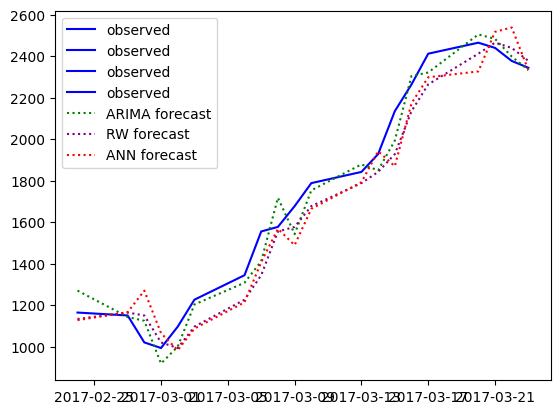

ARIMA RMSEs: 70.23440781644179
Random Walk RMSEs: 89.75
ANN RMSEs: 107.45779724121094


In [12]:

arima_rmses, rw_rmses, ann_rmses = ARIMA_vs_RW_vs_ANN(df, 
                                                      train_ratio=0.73, 
                                                      n_forecasts=20, 
                                                      months_ahead=1, 
                                                      plot=False, 
                                                      res=200, 
                                                      arima_spec=(1, 1, 2), 
                                                      ann_spec=(1, 2),
                                                      plot_all=True)

print(f"ARIMA RMSEs: {np.average(arima_rmses)}")
print(f"Random Walk RMSEs: {np.average(rw_rmses)}")
print(f"ANN RMSEs: {np.average(ann_rmses)}")
# Open the file in write mode
with open('log.txt', 'a') as file:
    print("Forecast:", file=file)
    print(f"ARIMA RMSEs: {np.average(arima_rmses)}", file=file)
    print(f"Random Walk RMSEs: {np.average(rw_rmses)}", file=file)
    print(f"ANN RMSEs: {np.average(ann_rmses)}", file=file)
    